In [4]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

S/G Separation Modeling
===

The general plan is:
- Set up the density of stars and galaxies. Originally this was expressed as a ratio of S/G for all sources brighter than a given limit (cumulative), but I switched this to differential galaxies and imposed a flat stellar density profile.
- Set up the distribution in size and magnitude of galaxies, making the 2D plot that should replicate the COSMOS results (which I will sometimes call a map, for lack of a better term).
- Define a "Classification Efficiency" value for each point in this size/magnitude plane, as a function of signal to noise ratio. This uses an approximation to a fitting function, should be replaced by a direct fit to the simulations.
- Now, given a 5$\sigma$-depth, I can compute the number of contaminants for each point in the size/magnitude plane that will leak into a stellar sample. 
- Summing this 2D array over size gives the number of galaxys vs magnitude, which can be compared to the number of stars vs magnitude. 


Star/Galaxy cumulative counts ratio
---

This has been replaced below by separate distributions for stars and galaxies.

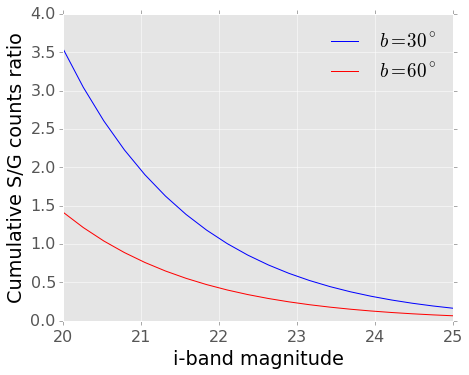

In [5]:
def cumulative_log_SG_ratio(galactic_lat, i_mag):
    """Returns the log of the ratio of stars to galaxies for
    all sources brighter than i_mag.
    galactic_lat is in degrees."""
    A = -1.3 - 0.28*(i_mag - 25) - 0.0025*(i_mag - 25.0)**2
    B = 2.3
    C = 20.0 # Degrees
    return A + B*exp(-abs(galactic_lat)/C)

i_mags = linspace(20,25,20)
plt.plot(i_mags, 10**cumulative_log_SG_ratio(30.0, i_mags), 'b-', label="$b=30^\circ$")
plt.plot(i_mags, 10**cumulative_log_SG_ratio(60.0, i_mags), 'r-', label="$b=60^\circ$")
plt.xlabel("i-band magnitude")
plt.ylabel("Cumulative S/G counts ratio")
plt.legend(frameon=False)

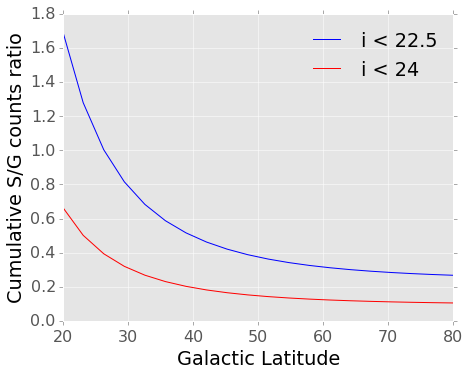

In [6]:
b_vals = linspace(20,80,20)
#i_limit = 23
plt.plot(b_vals, 10**cumulative_log_SG_ratio(b_vals, 22.5), 'b-', label="i < 22.5")
plt.plot(b_vals, 10**cumulative_log_SG_ratio(b_vals, 24), 'r-', label="i < 24")
plt.xlabel("Galactic Latitude")
plt.ylabel("Cumulative S/G counts ratio")
plt.legend(frameon=False)

Galaxy Size Distribution
=====

In [377]:
def galaxy_density_per_size_mag(theta, i_mag):
    """Returns the number of galaxies per square degree, per mag, per arcsec, with a 
    given size and a given i-band magnitude. 
    
    Note that theta needs to extend up to ~3 arcsec, otherwise when summing over
    the size distribution, significant numbers of bright galaxies will "disappear"
    since they are beyond that size.
    

    """
    size_lognorm_center = -0.24*i_mag + 5.02
    size_lognorm_sigma = -0.0136*i_mag + 0.778

    coeff = 1/(theta*size_lognorm_sigma*np.sqrt(2*np.pi))
    size_func = np.exp(-(np.log(theta)-size_lognorm_center)**2/(2*size_lognorm_sigma**2))
    
    # This is the differential version, equation C2
    #mag_func = 166000 * 10**(0.31*(i_mag - 25.0))
    
    # This is the analytic derivative, now per unit magnitude
    mag_func = 166000*10**(0.31*(i_mag - 25.0))*log(10)*0.31
    return coeff*size_func*mag_func

def galaxy_size_mag_grid(theta_arr, i_mag_arr):
    """Computes a grid of galaxy densities over size and magnitude by evaluating
    galaxy_density_per_size_mag() over the input theta and i_mag arrays.
    """
    ii, thetatheta = np.meshgrid(i_mag_arr, theta_arr)
    galaxy_density_map = galaxy_density_per_size_mag(thetatheta, ii)
    galaxy_density_map *= abs(i_mag_arr[0] - i_mag_arr[1]) * (theta_arr[1] - theta_arr[0])
    return galaxy_density_map
    

<matplotlib.colorbar.Colorbar instance at 0x1393520e0>

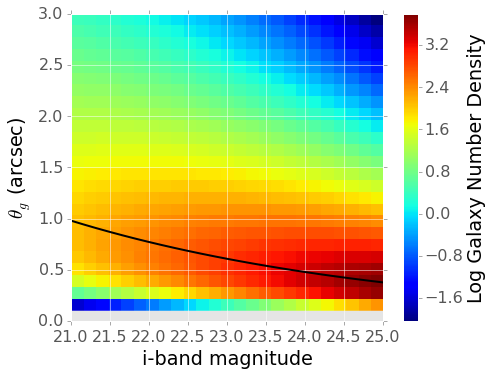

In [382]:
i_mags = np.linspace(21,25, 25)
theta_gs = np.linspace(0.1, 3.0, 25)
galaxy_density_map = galaxy_size_mag_grid(theta_gs, i_mags)

plt.imshow(np.log10(galaxy_density_map), interpolation="nearest",
           origin="lower",
           extent=(min(i_mags), max(i_mags), min(theta_gs), max(theta_gs)), aspect="auto")

size_lognorm_center = -0.24*i_mags + 5.02
size_lognorm_sigma = -0.0136*i_mags + 0.778
plt.plot(i_mags, exp(size_lognorm_center), 'k-', lw=2)
    
plt.xlabel("i-band magnitude")
plt.ylabel(r"$\theta_g$ (arcsec)")
plt.colorbar(label="Log Galaxy Number Density")

Classification Efficiency
----

I currently have the minimum required SNR to obtain a classification efficiency of C, written as a function of C. I need to invert this to obtain the classification efficiency of a given SNR observation.

[-0.00313542  0.07909383  0.47669706]


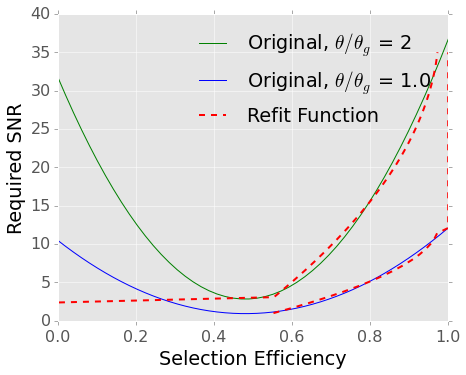

In [383]:
def SNR_from_C(C):
    return 10.5 - 39.8*C + 41.4*C**2

C_vals = linspace(0,1,50)
plt.plot(C_vals, SNR_from_C(C_vals)*(2.0)**1.6, 'g-', label=r"Original, $\theta/\theta_g$ = 2")
plt.plot(C_vals, SNR_from_C(C_vals), 'b-', label=r"Original, $\theta/\theta_g$ = 1.0")

# Only fit for C > 0.5 to avoid double-valued function
C_fitting_values= linspace(0.5,1, 50)
SNR_coeffs = np.polyfit(SNR_from_C(C_fitting_values), C_fitting_values, 2)
print SNR_coeffs

def C_from_SNR(SNR, theta_ratio=1.0):
    # This effective SNR scaling comes from Equation C5
    eff_SNR = SNR/theta_ratio**1.6
    
    fit_result = 0.4767 + 0.07909*eff_SNR - 0.00313*eff_SNR**2
    out = 1.0 * (eff_SNR > 12)
    out += fit_result * (eff_SNR <= 12) * (eff_SNR >= 1)
    out += 0.0 * (eff_SNR < 1) # For completeness
    
    return out

SNR_vals = linspace(1,35)
plt.plot(C_from_SNR(SNR_vals, theta_ratio=2.0), SNR_vals, 'r--', lw=2, label="Refit Function")
plt.plot(C_from_SNR(SNR_vals, theta_ratio=1.0), SNR_vals, 'r--', lw=2)
#plt.plot(np.polyval(SNR_coeffs, SNR_vals), SNR_vals, 'r--', lw=2)

plt.xlabel("Selection Efficiency")
plt.ylabel("Required SNR")
plt.xlim(0,1.0)
plt.legend(frameon=False)

Now that we have the selection efficiency given a SNR and galaxy/PSF size ratio, we can apply this to the size-magnitude plane for a given exposure depth (m5).

<matplotlib.colorbar.Colorbar instance at 0x12a2851b8>

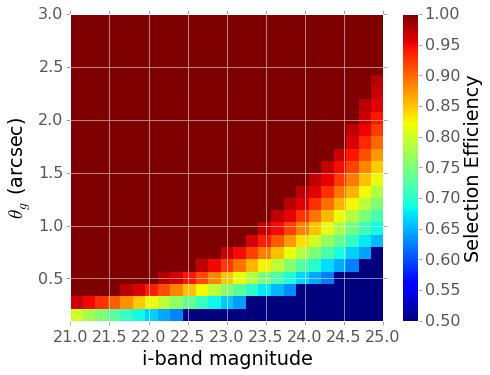

In [262]:
def SNR_from_m5(m5, mag, gamma=0.038):
    fluxRatio = 10**(-0.4*(m5 - mag))
    noiseSq = (0.04-gamma)*fluxRatio + gamma*fluxRatio**2
    return 1/np.sqrt(noiseSq)

def efficiency_map(theta_g, i_mag, m5=24.0, theta_obs=1.0):
    theta_ratio = theta_obs / theta_g
    SNR = SNR_from_m5(m5, i_mag)
    efficiency_C = C_from_SNR(SNR, theta_ratio=theta_ratio)
    return efficiency_C

eff_map_arr = efficiency_map(thetatheta, ii, m5=25.0, theta_obs=0.7)
plt.imshow(eff_map_arr, interpolation="nearest", origin="lower", vmin=0.5, #cmap="gray", 
           extent=(min(i_mags), max(i_mags), min(theta_gs), max(theta_gs)), aspect="auto")
plt.xlabel("i-band magnitude")
plt.ylabel(r"$\theta_g$ (arcsec)")
plt.colorbar(label="Selection Efficiency")

The contamination is thus $(1 - \rm{efficiency}) \times \rm{galaxy\_density}$ for each point in this plane.

/Users/ctslater/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


<matplotlib.colorbar.Colorbar instance at 0x12a513fc8>

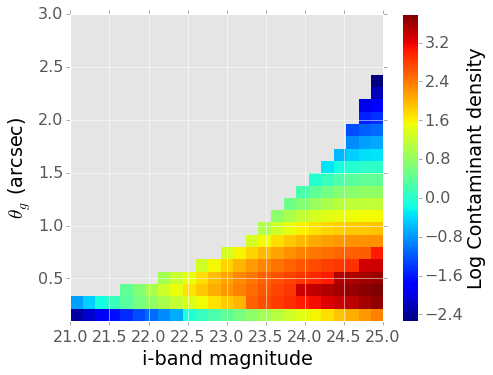

In [263]:
contamination_map = (1 - eff_map_arr)*galaxy_density_map
#SG_ratio_map = 
plt.imshow(np.log10(contamination_map), interpolation="nearest", origin="lower",
           extent=(min(i_mags), max(i_mags), min(theta_gs), max(theta_gs)), aspect="auto")
plt.xlabel("i-band magnitude")
plt.ylabel(r"$\theta_g$ (arcsec)")
plt.colorbar(label="Log Contaminant density")

Summing over $\theta_g$ in each magnitude bin gives the total number of contaminants, which can be compared to the total number of stars expected. This does not factor in stars misclassified as galaxies.

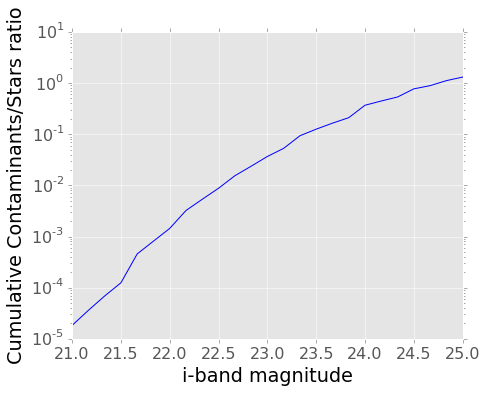

In [264]:
cumulative_contaminants = contamination_map.sum(axis=0)
Ngal = 166000 * 10**(0.31*(i_mags - 25.0))
galactic_lat = 45.0
cumulative_stars = Ngal*10**cumulative_log_SG_ratio(galactic_lat, i_mags)

plt.semilogy(i_mags, cumulative_contaminants/cumulative_stars, 'b-')
plt.ylabel("Cumulative Contaminants/Stars ratio")
plt.xlabel("i-band magnitude")

Refactoring
=====

This will duplicate the above, but in a class that's easier to call and can be imported to make a metric.

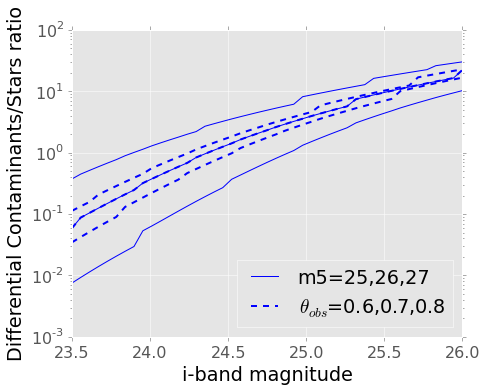

In [391]:
class StarGalaxySeparationModel:
    def cumulative_log_SG_ratio(self, galactic_lat, i_mag):
        """Returns the log of the ratio of stars to galaxies for
        all sources brighter than i_mag. This is only used for normalizing the stellar
        counts, and I'd like to get rid of it entirely.
        
        galactic_lat is in degrees."""
        A = -1.3 - 0.28*(i_mag - 25) - 0.0025*(i_mag - 25.0)**2
        B = 2.3
        C = 20.0 # Degrees
        return A + B*exp(-abs(galactic_lat)/C)
    
    def star_counts(self, galactic_lat, i_mag):
        """Returns stars per square degree per magnitude.

        Takes the cumulative_log_SG_ratio at i=21 as a normalization,
        then assumes that counts are flat per magnitude (r**-3 halo profile).
        """
        norm_magnitude = 21
        normalization_SG = self.cumulative_log_SG_ratio(galactic_lat, norm_magnitude)
        # Ngal is per square degree per magnitude
        Ngal = self.galaxy_counts(norm_magnitude)
        Nstar_norm = Ngal*10**(normalization_SG)

        # No magnitude dependence, but we want the shape of i_mag
        return Nstar_norm * (i_mag**0)
    
    def galaxy_counts(self, i_mag):
        """Galaxy counts per square degree per magnitude"""
        # Old cumulative version, equation C2
        #mag_func = 166000 * 10**(0.31*(i_mag - 25.0))

        Ngal = 166000*10**(0.31*(i_mag - 25.0))*log(10)*0.31
        return Ngal

    def galaxy_density_per_size_mag(self, theta, i_mag):
        """Returns the number of galaxies per square degree with a given size
        and a given i-band magnitude. 

        Note that theta needs to extend up to ~3 arcsec, otherwise when summing over
        the size distribution, significant numbers of bright galaxies will "disappear"
        since they are beyond that size.
        """
        size_lognorm_center = -0.24*i_mag + 5.02
        size_lognorm_sigma = -0.0136*i_mag + 0.778

        coeff = 1/(theta*size_lognorm_sigma*np.sqrt(2*np.pi))
        size_func = np.exp(-(np.log(theta)-size_lognorm_center)**2/(2*size_lognorm_sigma**2))

        mag_func = self.galaxy_counts(i_mag)

        return coeff*size_func*mag_func

    def galaxy_size_mag_grid(self, theta_arr, i_mag_arr):
        """Computes a grid of galaxy densities over size and magnitude by evaluating
        galaxy_density_per_size_mag() over the input theta and i_mag arrays.
        """
        ii, thetatheta = np.meshgrid(i_mag_arr, theta_arr)
        galaxy_density_map = galaxy_density_per_size_mag(thetatheta, ii)
        galaxy_density_map *= abs(i_mag_arr[0] - i_mag_arr[1]) * (theta_arr[1] - theta_arr[0])
        return galaxy_density_map

    def C_from_SNR(self, SNR, theta_ratio=1.0):
        # This effective SNR scaling comes from Equation C5
        eff_SNR = SNR/theta_ratio**1.6

        fit_result = 0.4767 + 0.07909*eff_SNR - 0.00313*eff_SNR**2
        out = 1.0 * (eff_SNR > 12)
        out += fit_result * (eff_SNR <= 12) * (eff_SNR >= 1)
        out += 0.0 * (eff_SNR < 1) # For completeness

        return out

    def SNR_from_m5(self, m5, mag, gamma=0.038):
        fluxRatio = 10**(-0.4*(m5 - mag))
        noiseSq = (0.04-gamma)*fluxRatio + gamma*fluxRatio**2
        return 1/np.sqrt(noiseSq)

    def efficiency_map(self, theta_g, i_mag, m5=24.0, theta_obs=1.0):
        theta_ratio = theta_obs / theta_g
        SNR = self.SNR_from_m5(m5, i_mag)
        efficiency_C = self.C_from_SNR(SNR, theta_ratio=theta_ratio)
        return efficiency_C
    
    def make_differential_contamination(self, i_mags, m5=25, theta_obs=0.7, galactic_lat=45):
        theta_gs = np.linspace(0.1, 3.0, 40)
        ii, thetatheta = np.meshgrid(i_mags, theta_gs)
        eff_map_arr = self.efficiency_map(thetatheta, ii, m5=m5, theta_obs=theta_obs)
        
        galaxy_density_map = self.galaxy_size_mag_grid(theta_gs, i_mags)
        contamination_map = (1 - eff_map_arr)*galaxy_density_map
        differential_contaminants = contamination_map.sum(axis=0)
        
        d_mag = abs(i_mags[1] - i_mags[0])
        Nstars = self.star_counts(galactic_lat, i_mags)*d_mag
        return differential_contaminants/Nstars

        
sg_model = StarGalaxySeparationModel()

contam_i_mags = linspace(23.5,26,45)
for m5 in [25,26,27]:
    contam_ratio = sg_model.make_differential_contamination(contam_i_mags,
                                                            m5=m5,
                                                            theta_obs=0.7)
    line_m5, = plt.semilogy(contam_i_mags, contam_ratio, 'b-')
    
for theta_obs in [0.6,0.7,0.8]:
    contam_ratio = sg_model.make_differential_contamination(contam_i_mags,
                                                            m5=26,
                                                            theta_obs=theta_obs)
    line_theta, = plt.semilogy(contam_i_mags, contam_ratio, 'b--', lw=2)

# could increase the depth to account for seeing by making 
# m5 = 26 - 2.5*log10(old_seeing/new_seeing).
# For 0.1 arcsec change in seeing, m5 change is 0.14

plt.legend([line_m5, line_theta], ["m5=25,26,27", r"$\theta_{obs}$=0.6,0.7,0.8"],
          loc="lower right")
plt.ylabel("Differential Contaminants/Stars ratio")
plt.xlabel("i-band magnitude")



An easier way to show the difference between observing strategies is to compute a "Star/Galaxy separation limit", which I define as when the ratio of contaminants to stars is unity.

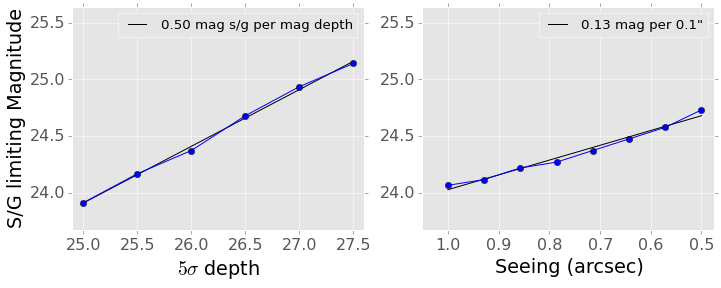

In [394]:
contam_i_mags = linspace(23.5,25.5,40)
# I'm defining sg_limit as the magnitude where contam/stars=1
m5_mags = [25,25.5,26,26.5,27,27.5]
sg_limit_vs_m5 = []
for m5 in m5_mags:
    
    contam_stars_ratio = sg_model.make_differential_contamination(contam_i_mags,
                                                                   m5=m5,
                                                                   theta_obs=0.7)
    limit_mag = contam_i_mags[min(np.argwhere(contam_stars_ratio > 1))]
    sg_limit_vs_m5.append(limit_mag)
    
sg_limit_vs_theta = []
thetas = np.linspace(0.5, 1.0,8)
m5 = 26.0
for theta in thetas:

    contam_stars_ratio = sg_model.make_differential_contamination(contam_i_mags,
                                                                   m5=m5,
                                                                   theta_obs=theta)
    limit_mag = contam_i_mags[min(np.argwhere(contam_stars_ratio > 1))]
    sg_limit_vs_theta.append(limit_mag)

plt.figure(None, figsize=(11.5,4))
plt.subplot(1,2,1)


fit = np.polyfit(m5_mags, sg_limit_vs_m5,1)
slope = "{:.2f} mag s/g per mag depth".format(float(fit[0]))
plt.plot(m5_mags, polyval(fit, m5_mags), 'k-', label=slope)
plt.plot(m5_mags, sg_limit_vs_m5, 'bo-')

plt.xlabel(r"$5\sigma$ depth")
plt.ylabel("S/G limiting Magnitude")
plt.ylim(0.99*min(min(sg_limit_vs_m5), min(sg_limit_vs_theta)),
         1.02*max(max(sg_limit_vs_m5), max(sg_limit_vs_theta)))
plt.xlim(min(m5_mags)-0.1,max(m5_mags)+0.1)
plt.legend(fontsize="small")


plt.subplot(1,2,2)

fit = np.polyfit(thetas, sg_limit_vs_theta,1)
slope = "{:.2f} mag per 0.1\"".format(float(fit[0])/-10)
plt.plot(thetas, polyval(fit, thetas), 'k-', label=slope)
plt.plot(thetas, sg_limit_vs_theta, 'bo-')

plt.xlabel(r"Seeing (arcsec)")
plt.ylim(0.99*min(min(sg_limit_vs_m5), min(sg_limit_vs_theta)),
         1.02*max(max(sg_limit_vs_m5), max(sg_limit_vs_theta)))
plt.xlim(max(thetas)*1.05,min(thetas)*0.95)
plt.legend(fontsize="small")
    

For comparison, the "Pan-STARRS-like" cadence has 8% worse median seeing, which is 0.056", and yields a S/G degredation of 0.07 magnitudes. That is pretty small. The coadded depth is 0.15 mag shallower, which gives a similar degredation in S/G of 0.07 mags. The combined degredation of 0.15 mag seems small compared to the area gained by the Pan-STARRS cadence.

Debug
---

Code below this point is mostly tests for functions described above.

0.043751088949 0.112828965396
0.999977179017 1.00015072437 0.999706648512


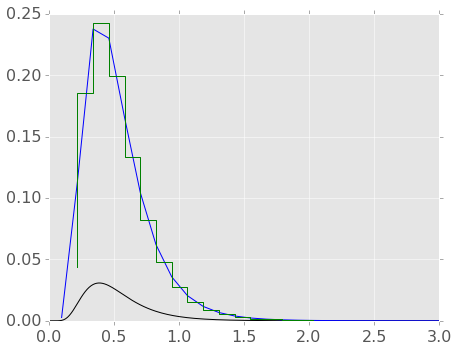

In [91]:
from scipy.special import erf
def size_func(theta, i_mag=24):
    size_lognorm_center = -0.24*i_mag + 5.02
    size_lognorm_sigma = -0.0136*i_mag + 0.778
    coeff = 1/(theta*size_lognorm_sigma*np.sqrt(2*np.pi))
    out = np.exp(-(np.log(theta)-size_lognorm_center)**2/(2*size_lognorm_sigma**2))
    delta_theta = (theta[1] - theta[0])
    return coeff*out*delta_theta

def size_func_erf(thetas, i_mag=24):
    size_lognorm_center = -0.24*i_mag + 5.02
    size_lognorm_sigma = -0.0136*i_mag + 0.778
    out = 0.5*(erf((np.log(thetas[1:]) - size_lognorm_center)/size_lognorm_sigma/sqrt(2)) -
               erf((np.log(thetas[:-1]) - size_lognorm_center)/size_lognorm_sigma/sqrt(2)))
    return out
    
thetas = np.linspace(0.1, 3.0, 25)
x = np.linspace(0.01, 3.0, 200)
plt.plot(x, size_func(x), 'k-')
plt.plot(thetas, size_func(thetas), 'b-')
plt.plot(thetas[1:], size_func_erf(thetas), 'g-', drawstyle='steps-pre')
print size_func_erf(thetas)[0], size_func(thetas)[1]
print sum(size_func(x)), sum(size_func(thetas)), sum(size_func_erf(thetas))

(0, 10)

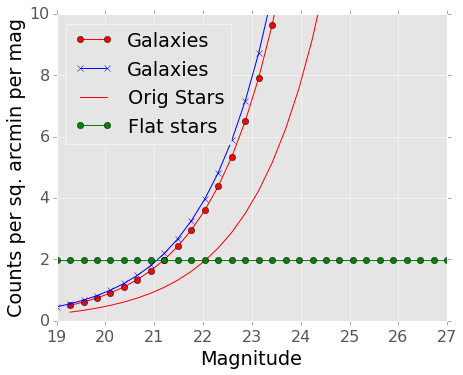

In [375]:
def star_counts(galactic_lat, i_mag):
    """Returns stars per square degree per magnitude.
    
    Takes the cumulative_log_SG_ratio at i=21 as a normalization,
    then assumes that counts are flat per magnitude (r**-3 halo profile).
    """
    norm_magnitude = 21
    normalization_SG = cumulative_log_SG_ratio(galactic_lat, norm_magnitude)
    # Ngal is per square degree per magnitude
    Ngal = 166000*10**(0.31*(norm_magnitude - 25.0))*log(10)*0.31
    Nstar_norm = Ngal*10**(normalization_SG)
    
    # No magnitude dependence, but we want the shape of i_mag
    return Nstar_norm * (i_mag**0)
    
# Cumulative, per sq arcmin
mag_func = lambda x: 166000 * 10**(0.31*(x - 25.0)) / 3600.0

# Now differential, per bin in x
x = np.linspace(19,27, 30)
diff_galaxy_counts = (mag_func(x[1:]) - mag_func(x[:-1])) #/np.abs((x[1:] - x[:-1]))

#plt.plot(x, mag_func(x), 'bo-', label="Galaxies")

dx = x[1] - x[0]
plt.plot(x[1:], diff_galaxy_counts/dx, 'r-o', label="Galaxies")
plt.plot(x, 166000*10**(0.31*(x - 25.0))*log(10)*0.31/3600, 'bx-', label="Galaxies")
plt.plot(x[1:], galaxy_counts*10**differential_log_SG_ratio(45, x[1:])/dx, 'r-',
         label="Orig Stars")
plt.plot(x, star_counts(45, x)/3600.0, 'g-o', label="Flat stars")


plt.ylabel("Counts per sq. arcmin per mag")
plt.xlabel("Magnitude")
plt.legend(loc="upper left")
plt.ylim(0,10)

Given the rapid increase in the number of galaxies and the approximately fixed ratio of galaxies to stars, this predicts that the number of stars will increase significantly at fainter magnitudes. I don't believe that this is the case, particularly not for a fixed color selection. Is this instead counting objects further down the main sequence?

Have since altered the flow so that star counts are computed independently (but normalized to galaxy counts at i=21), with a $r^{-3}$ profile.